In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"Keras Version: {keras.__version__}")

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Keras Version: 3.10.0


This cell imports essential libraries. TensorFlow and Keras provide deep learning functionality. Matplotlib and Seaborn enable visualization. We verify GPU availability, which dramatically accelerates training (10-50× speedup). If no GPU is available, Colab's runtime can be changed to GPU via Runtime → Change runtime type → Hardware accelerator → GPU.

In [4]:
# Install Kaggle API
!pip install -q kaggle

# Upload your kaggle.json file to Colab
# Go to Kaggle.com → Account → API → Create New API Token
# Upload the downloaded kaggle.json file using the following:
from google.colab import files
print("Upload your kaggle.json file:")
files.upload()

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset (using Waste Classification Dataset as example)
# Change the dataset path based on which dataset you choose
!kaggle datasets download -d techsash/waste-classification-data
!unzip -q waste-classification-data.zip -d /content/waste_data

print("Dataset downloaded and extracted successfully!")

# Check extracted structure
!ls -R /content/waste_data

Upload your kaggle.json file:


Streaming output truncated to the last 5000 lines.
R_1781.jpg  R_3281.jpg	R_4782.jpg  R_6282.jpg	R_7783.jpg  R_9283.jpg
R_1782.jpg  R_3282.jpg	R_4783.jpg  R_6283.jpg	R_7784.jpg  R_9284.jpg
R_1783.jpg  R_3283.jpg	R_4784.jpg  R_6284.jpg	R_7785.jpg  R_9285.jpg
R_1784.jpg  R_3284.jpg	R_4785.jpg  R_6285.jpg	R_7786.jpg  R_9286.jpg
R_1785.jpg  R_3285.jpg	R_4786.jpg  R_6286.jpg	R_7787.jpg  R_9287.jpg
R_1786.jpg  R_3286.jpg	R_4787.jpg  R_6287.jpg	R_7788.jpg  R_9288.jpg
R_1787.jpg  R_3287.jpg	R_4788.jpg  R_6288.jpg	R_7789.jpg  R_9289.jpg
R_1788.jpg  R_3288.jpg	R_4789.jpg  R_6289.jpg	R_778.jpg   R_928.jpg
R_1789.jpg  R_3289.jpg	R_478.jpg   R_628.jpg	R_7790.jpg  R_9290.jpg
R_178.jpg   R_328.jpg	R_4790.jpg  R_6290.jpg	R_7791.jpg  R_9291.jpg
R_1790.jpg  R_3290.jpg	R_4791.jpg  R_6291.jpg	R_7792.jpg  R_9292.jpg
R_1791.jpg  R_3291.jpg	R_4792.jpg  R_6292.jpg	R_7793.jpg  R_9293.jpg
R_1792.jpg  R_3292.jpg	R_4793.jpg  R_6293.jpg	R_7794.jpg  R_9294.jpg
R_1793.jpg  R_3293.jpg	R_4794.jpg  R_6294.jpg	R_7795.jp

Methods is provided for dataset access. **(Kaggle API)** directly downloads datasets from Kaggle into Colab, which is faster and doesn't require manual downloads. You need a Kaggle account and API token (kaggle.json). The code verifies paths and lists detected classes, helping catch configuration errors before training begins.

In [9]:
DATASET_PATH = '/content/waste_data/DATASET'

TRAIN_DIR = os.path.join(DATASET_PATH, 'TRAIN')
VALIDATION_DIR = os.path.join(DATASET_PATH, 'TEST')


# Verify paths exist
print(f"Training directory exists: {os.path.exists(TRAIN_DIR)}")
print(f"Validation directory exists: {os.path.exists(VALIDATION_DIR)}")

# List class folders
if os.path.exists(TRAIN_DIR):
    classes = sorted(os.listdir(TRAIN_DIR))
    print(f"\nDetected Classes: {classes}")
    print(f"Number of Classes: {len(classes)}")

# Hyperparameters
IMG_SIZE = (224, 224)  # MobileNetV2 expects 224x224 RGB images
BATCH_SIZE = 32        # Number of images per training batch
EPOCHS = 20            # Number of complete passes through training data
LEARNING_RATE = 0.001  # Adam optimizer learning rate
NUM_CLASSES = len(classes)         # Number of waste categories

# Class names (ensure these match your folder names exactly)
CLASS_NAMES = sorted(os.listdir(TRAIN_DIR))


print(f"Image Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Training Epochs: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Number of Classes: {NUM_CLASSES}")


Training directory exists: True
Validation directory exists: True

Detected Classes: ['O', 'R']
Number of Classes: 2
Image Size: (224, 224)
Batch Size: 32
Training Epochs: 20
Learning Rate: 0.001
Number of Classes: 2


Centralized hyperparameter configuration enables easy experimentation. Image size 224×224 matches MobileNetV2's training resolution. Batch size 32 balances memory constraints and gradient noise. 20 epochs typically suffice for transfer learning convergence. Learning rate 0.001 is Adam's default, appropriate for fine-tuning.

In [10]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0,1]
    rotation_range=20,           # Random rotation ±20 degrees
    width_shift_range=0.2,       # Random horizontal shift ±20%
    height_shift_range=0.2,      # Random vertical shift ±20%
    shear_range=0.2,             # Shear transformation
    zoom_range=0.2,              # Random zoom 80-120%
    horizontal_flip=True,        # Random horizontal mirroring
    fill_mode='nearest'          # Fill strategy for created pixels
)

# Validation data generator (only rescaling, NO augmentation)
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',    # One-hot encoded labels
    shuffle=True,                # Shuffle training data
    seed=42                      # Reproducibility
)

# Load validation data
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,               # Don't shuffle validation data
    seed=42
)

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Class indices mapping: {train_generator.class_indices}")

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.

Training samples: 22564
Validation samples: 2513
Class indices mapping: {'O': 0, 'R': 1}


`ImageDataGenerator` handles both augmentation and batch loading. For training, we apply stochastic transformations to artificially expand the dataset. For validation, only rescaling is applied—augmentation would artificially inflate validation performance. `flow_from_directory` automatically infers class labels from subdirectory names and converts them to one-hot vectors for categorical crossentropy. Setting `shuffle=False` for validation ensures reproducible evaluation.

Sample Augmented Training Images:


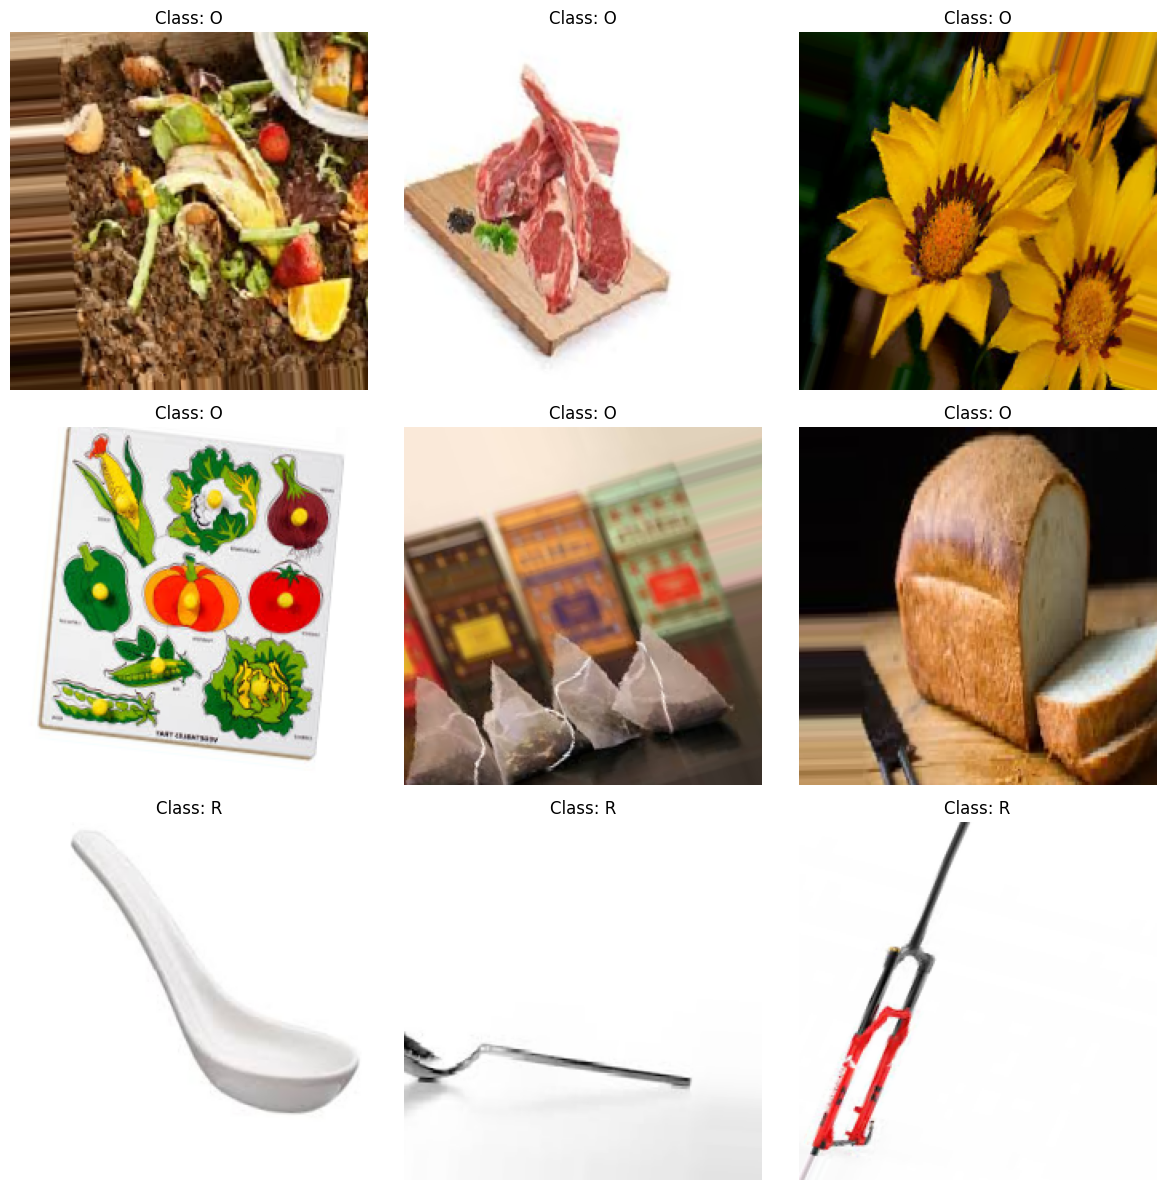

Sample images saved to: /content/sample_augmented_images.png


In [11]:
### 5.5 Visualize Sample Batch

# Visualize sample augmented images
def plot_sample_images(generator, num_images=9):
    """Display a grid of sample images with labels"""
    batch_images, batch_labels = next(generator)

    plt.figure(figsize=(12, 12))
    for i in range(min(num_images, len(batch_images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(batch_images[i])
        class_idx = np.argmax(batch_labels[i])
        class_name = CLASS_NAMES[class_idx]
        plt.title(f"Class: {class_name}")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('/content/sample_augmented_images.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Sample images saved to: /content/sample_augmented_images.png")

# Display training samples
print("Sample Augmented Training Images:")
plot_sample_images(train_generator)

Visualizing data before training is crucial for catching preprocessing errors: incorrect labels, excessive augmentation causing unrecognizable images, or normalization failures. This function displays a 3×3 grid of augmented training images with their class labels, allowing visual verification that the pipeline functions correctly.

In [15]:
# Load MobileNetV2 pre-trained on ImageNet
base_model = MobileNetV2(
    input_shape=(224, 224, 3),   # Input dimensions
    include_top=False,           # Exclude original classification head
    weights='imagenet'           # Use ImageNet pre-trained weights
)

# Freeze base model layers (feature extraction mode)
base_model.trainable = False

print(f"Base Model: MobileNetV2")
print(f"Total layers in base model: {len(base_model.layers)}")
print(f"Trainable status: {base_model.trainable}")

# Build custom classification head
inputs = keras.Input(shape=(224, 224, 3))

# Pass through frozen base model
x = base_model(inputs, training=False)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)          # Spatial pooling
x = layers.Dense(128, activation='relu')(x)     # Feature compression
x = layers.Dropout(0.3)(x)                      # Regularization
outputs = layers.Dense(2, activation='softmax')(x)  # 6-class output

# Create final model
model = Model(inputs, outputs, name='waste_classifier')

print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)
model.summary()

Base Model: MobileNetV2
Total layers in base model: 154
Trainable status: False

MODEL ARCHITECTURE


Model: "waste_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

We instantiate MobileNetV2 with ImageNet weights but exclude its original classification head (`include_top=False`). Setting `base_model.trainable=False` freezes all convolutional layers, preserving learned features while training only the custom head. This dramatically reduces training time and prevents overfitting on small datasets. The Functional API enables flexible model construction, passing inputs through the frozen base then through our custom classification layers.

In [16]:
# Compile model with loss, optimizer, and metrics
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
print(f"Optimizer: Adam (lr={LEARNING_RATE})")
print(f"Loss Function: Categorical Crossentropy")
print(f"Metrics: Accuracy")


Model compiled successfully!
Optimizer: Adam (lr=0.001)
Loss Function: Categorical Crossentropy
Metrics: Accuracy


Model compilation configures training. Adam optimizer with learning rate 0.001 provides adaptive per-parameter updates. Categorical crossentropy is the standard multi-class classification loss. Accuracy metric tracks proportion of correct predictions, providing an intuitive performance measure.


In [17]:
# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',          # Monitor validation loss
    patience=5,                  # Stop if no improvement for 5 epochs
    restore_best_weights=True,   # Restore weights from best epoch
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,                  # Reduce LR by half
    patience=3,                  # After 3 epochs without improvement
    min_lr=1e-7,
    verbose=1
)

# Train the model
print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)


STARTING TRAINING
Epoch 1/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 306s 409ms/step - accuracy: 0.8917 - loss: 0.2692 - val_accuracy: 0.8197 - val_loss: 0.3777 - learning_rate: 0.0010
Epoch 2/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 261s 370ms/step - accuracy: 0.9328 - loss: 0.1770 - val_accuracy: 0.8870 - val_loss: 0.2703 - learning_rate: 0.0010
Epoch 3/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 256s 362ms/step - accuracy: 0.9387 - loss: 0.1575 - val_accuracy: 0.8357 - val_loss: 0.3468 - learning_rate: 0.0010
Epoch 4/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 258s 365ms/step - accuracy: 0.9466 - loss: 0.1444 - val_accuracy: 0.8365 - val_loss: 0.3756 - learning_rate: 0.0010
Epoch 5/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9477 - loss: 0.1405
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
706/706 ━━━━━━━━━━━━━━━━━━━━ 258s 366ms/step - accuracy: 0.9477 - loss: 0.1405 - val_accuracy: 0.8094 - val_loss: 0.4184 - learning_rate: 0.0010
Epoch 6/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 257s 364

Callbacks enable sophisticated training control. `EarlyStopping` monitors validation loss and halts training if it doesn't improve for 5 consecutive epochs, preventing overfitting and saving time. `ReduceLROnPlateau` automatically reduces learning rate when validation loss plateaus, enabling finer optimization. The `fit` method executes training, iterating through the dataset for the specified number of epochs.

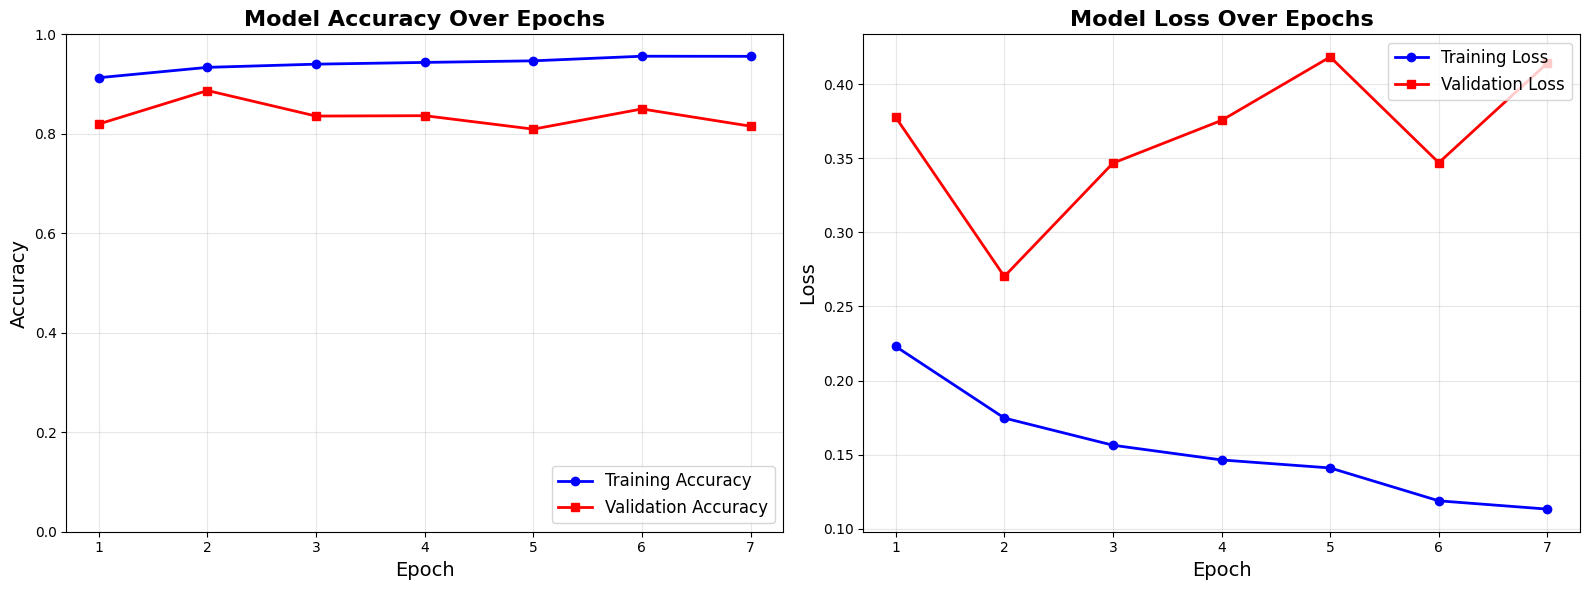


Training history plot saved to: /content/training_history.png

Final Training Accuracy: 0.9558
Final Validation Accuracy: 0.8154
Final Training Loss: 0.1132
Final Validation Loss: 0.4143


In [18]:
# Extract training metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, len(train_loss) + 1)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot accuracy
ax1.plot(epochs_range, train_acc, 'b-o', label='Training Accuracy', linewidth=2)
ax1.plot(epochs_range, val_acc, 'r-s', label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy Over Epochs', fontsize=16, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.legend(loc='lower right', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Plot loss
ax2.plot(epochs_range, train_loss, 'b-o', label='Training Loss', linewidth=2)
ax2.plot(epochs_range, val_loss, 'r-s', label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss Over Epochs', fontsize=16, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Loss', fontsize=14)
ax2.legend(loc='upper right', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTraining history plot saved to: /content/training_history.png")
print(f"\nFinal Training Accuracy: {train_acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")
print(f"Final Training Loss: {train_loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")

Visualizing training curves is essential for diagnosing model behavior. The left plot shows accuracy progression; the right shows loss. Ideally, both training and validation metrics improve together. Divergence between training and validation curves indicates overfitting (discussed in Results section). This code generates a publication-quality figure saved to Colab's local storage.

In [19]:
# Reset validation generator to ensure complete pass
validation_generator.reset()

# Generate predictions on validation set
print("Generating predictions on validation set...")
y_pred_probs = model.predict(validation_generator, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Extract true labels
y_true = validation_generator.classes

print(f"\nPredicted classes shape: {y_pred_classes.shape}")
print(f"True labels shape: {y_true.shape}")
print(f"Sample predictions: {y_pred_classes[:10]}")
print(f"Sample true labels: {y_true[:10]}")

Generating predictions on validation set...
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step

Predicted classes shape: (2513,)
True labels shape: (2513,)
Sample predictions: [0 0 0 0 0 1 1 0 0 0]
Sample true labels: [0 0 0 0 0 0 0 0 0 0]


We generate predictions on the validation set to compute detailed performance metrics. `model.predict()` returns probability distributions for each sample; `np.argmax()` converts these to class indices. `validation_generator.classes` provides the true integer labels. Resetting the generator ensures we process the complete validation set exactly once.

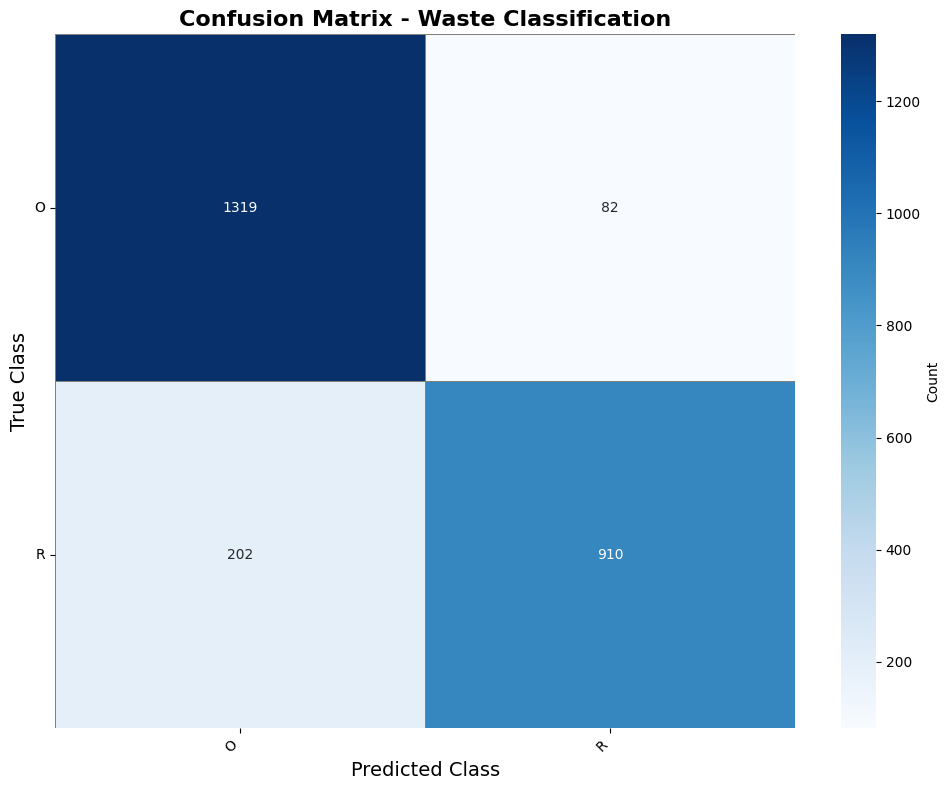

Confusion matrix saved to: /content/confusion_matrix.png

CONFUSION MATRIX ANALYSIS
O           : 1319/1401 correct (94.15%)
R           : 910/1112 correct (81.83%)


In [20]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,           # Show values in cells
    fmt='d',              # Integer format
    cmap='Blues',         # Color scheme
xticklabels=CLASS_NAMES,
yticklabels=CLASS_NAMES,

    cbar_kws={'label': 'Count'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title('Confusion Matrix - Waste Classification', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('True Class', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("Confusion matrix saved to: /content/confusion_matrix.png")

# Print confusion matrix analysis
print("\n" + "="*60)
print("CONFUSION MATRIX ANALYSIS")
print("="*60)
for i, class_name in enumerate(CLASS_NAMES):
    total_samples = np.sum(cm[i, :])
    correct_predictions = cm[i, i]
    class_accuracy = (correct_predictions / total_samples) * 100 if total_samples > 0 else 0
    print(f"{class_name.capitalize():12s}: {correct_predictions:3d}/{total_samples:3d} correct ({class_accuracy:.2f}%)")

The confusion matrix reveals where the model makes errors. Rows represent true classes; columns represent predictions. Diagonal elements indicate correct classifications; off-diagonal elements show misclassifications. This visualization immediately highlights problematic class pairs (e.g., if glass and plastic are frequently confused). Per-class accuracy calculation identifies which categories perform best/worst.

In [21]:
# Generate detailed classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
report = classification_report(
    y_true,
    y_pred_classes,
    target_names=CLASS_NAMES,
    digits=4
)
print(report)

# Save report to file
with open('/content/classification_report.txt', 'w') as f:
    f.write("WASTE CLASSIFICATION MODEL - EVALUATION REPORT\n")
    f.write("="*60 + "\n\n")
    f.write(report)
print("\nClassification report saved to: /content/classification_report.txt")


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           O     0.8672    0.9415    0.9028      1401
           R     0.9173    0.8183    0.8650      1112

    accuracy                         0.8870      2513
   macro avg     0.8923    0.8799    0.8839      2513
weighted avg     0.8894    0.8870    0.8861      2513


Classification report saved to: /content/classification_report.txt


Scikit-learn's `classification_report()` computes precision, recall, F1-score, and support (sample count) for each class, plus macro and weighted averages. This provides a comprehensive performance summary beyond simple accuracy. The report is saved as a text file for documentation.

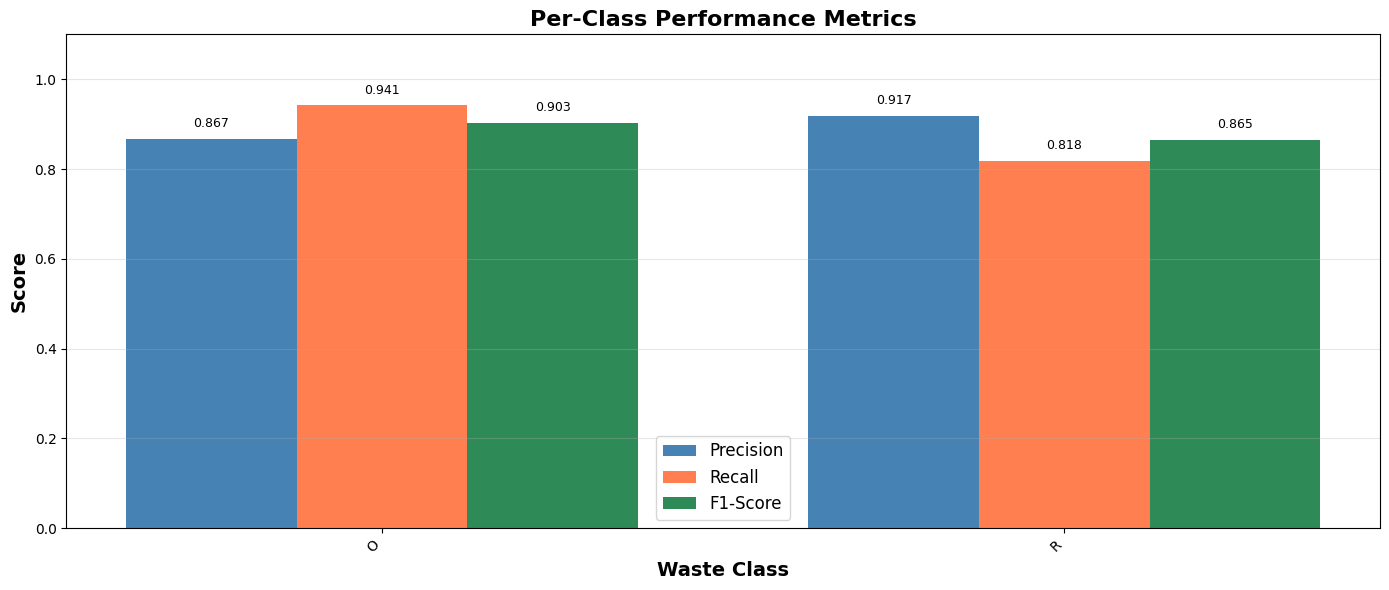

Per-class metrics plot saved to: /content/per_class_metrics.png


In [22]:
# Extract per-class metrics for visualization
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_true,
    y_pred_classes,
    average=None,
    labels=range(NUM_CLASSES)
)

# Create bar plot
x_pos = np.arange(len(CLASS_NAMES))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x_pos - width, precision, width, label='Precision', color='steelblue')
bars2 = ax.bar(x_pos, recall, width, label='Recall', color='coral')
bars3 = ax.bar(x_pos + width, f1, width, label='F1-Score', color='seagreen')

ax.set_xlabel('Waste Class', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=14, fontweight='bold')
ax.set_title('Per-Class Performance Metrics', fontsize=16, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(CLASS_NAMES, rotation=45, ha='right')
ax.legend(fontsize=12)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('/content/per_class_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("Per-class metrics plot saved to: /content/per_class_metrics.png")

This visualization compares precision, recall, and F1-score across all classes, making performance disparities immediately apparent. Classes with low recall may require additional training data; classes with low precision may be visually similar to other categories. This diagnostic helps prioritize improvement efforts.

In [24]:
# 1️⃣ Save complete model (recommended modern format)
model_save_path = '/content/waste_classifier_model.keras'
model.save(model_save_path)
print(f"Complete model saved to: {model_save_path}")

# 2️⃣ Save model architecture as JSON (optional)
model_json = model.to_json()
with open('/content/waste_classifier_architecture.json', 'w') as json_file:
    json_file.write(model_json)
print("Model architecture saved to: waste_classifier_architecture.json")

# 3️⃣ Save only weights (filename must end with .weights.h5)
weights_path = '/content/waste_classifier.weights.h5'
model.save_weights(weights_path)
print(f"Model weights saved to: {weights_path}")

print("\n" + "="*60)
print("MODEL SAVING COMPLETE")
print("="*60)

print("\nTo load later:")
print("from tensorflow.keras.models import load_model")
print("model = load_model('/content/waste_classifier_model.keras')")

Complete model saved to: /content/waste_classifier_model.keras
Model architecture saved to: waste_classifier_architecture.json
Model weights saved to: /content/waste_classifier.weights.h5

MODEL SAVING COMPLETE

To load later:
from tensorflow.keras.models import load_model
model = load_model('/content/waste_classifier_model.keras')


Saving the trained model enables future use without retraining. The `.h5` format (HDF5) stores architecture, weights, optimizer state, and compilation configuration in a single file. Saving architecture separately as JSON and weights separately as `.h5` provides modular options for deployment scenarios. Models saved to Google Drive persist across Colab sessions.



Testing inference on: /content/waste_data/DATASET/TEST/O/O_13771.jpg


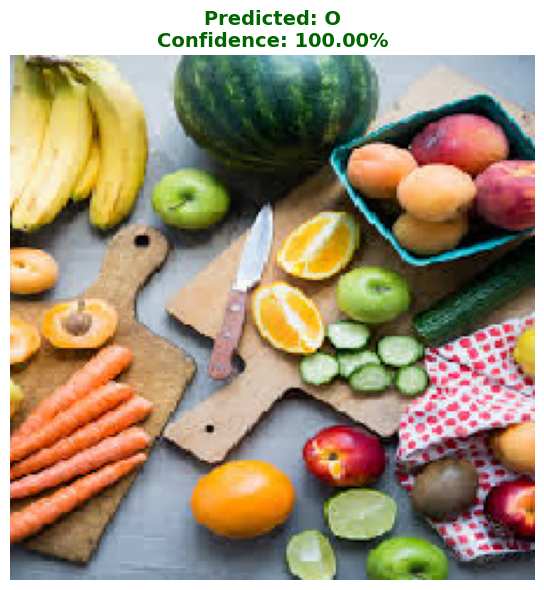

Prediction: O
Confidence: 100.00%


In [26]:
# Example: Predict on a validation image (O or R)

example_class = CLASS_NAMES[0]   # Automatically selects 'O' or 'R'

example_image_path = os.path.join(
    VALIDATION_DIR,
    example_class,
    os.listdir(os.path.join(VALIDATION_DIR, example_class))[0]
)

print(f"\nTesting inference on: {example_image_path}")

pred_class, conf = predict_waste_class(example_image_path, loaded_model)

print(f"Prediction: {pred_class}")
print(f"Confidence: {conf:.2%}")


This demonstrates practical deployment usage. The `predict_waste_class()` function handles the complete inference pipeline: loading an image, preprocessing (resize, normalize, batch dimension), prediction, and visualization. This pattern can be adapted for web applications, mobile apps, or embedded systems. Testing immediately after saving verifies that the saved model loads and functions correctly.